In [44]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [45]:
import numpy as np
import pandas as pd

In [46]:


import seaborn as sns
from datetime import datetime, timedelta, date
from flask import Flask, jsonify

# Reflect Tables into SQLAlchemy ORM

In [47]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,MetaData, Table,inspect,extract

In [48]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite" )

In [49]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [50]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [51]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [52]:
inspector = inspect(engine)

inspector.get_table_names()

['measurement', 'station']

In [53]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [54]:
# print list of column names for Measurements
columns_M = inspector.get_columns('Measurement')

for column in columns_M:
    print(column['name'], column['type'])
    #tobs is temp

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [55]:
 #print list of column names for Stations
columns_S = inspector.get_columns('Station')

for column in columns_S:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [56]:
# *** save a reference to those classes called `Station` and `Measurement`. ***
Stations = Base.classes.station
Measurements = Base.classes.measurement

# Create session
session = Session(engine)

In [57]:
# Check the data
for instance in session.query(Measurements.tobs).limit(10).all():
    print(instance)

(65.0,)
(63.0,)
(74.0,)
(76.0,)
(73.0,)
(70.0,)
(64.0,)
(68.0,)
(73.0,)
(64.0,)


In [58]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# *** Retrieve the last 12 months of precipitation data. Select only the `date` and `prcp` values. ***
    # first find latest date, which turns out to be '2017-08-23'
Latest_date = session.query(Measurements.date).group_by(Measurements.date).order_by(Measurements.date.desc()).first()
Latest_date = pd.to_datetime(Latest_date)
    # Note: HAVE to convert to datetime object first. Apparently python can't subtract from date object.
Latest_date = Latest_date[0] # selects the timestamp

    # subtract one year from it
year_date = Latest_date - timedelta(days=365)

year_date

Timestamp('2016-08-23 00:00:00')

In [59]:
# *** Query the last 12 months, averaging precip between the various weather stations ***
Last12Precip = session.query(Measurements.date, Stations.name, Measurements.prcp)\
                            .join(Station, Measurements.station == Stations.station)\
                            .order_by(Measurements.date.desc())
    # note, specific datetime has to be this format 'yyyy-mm-dd' 
    
Last12Precip[0:5]
Last12Precip[-1]

('2010-01-01', 'MANOA LYON ARBO 785.2, HI US', 0.14)

In [60]:
# saving dates and prcp values from the query
date = [row[0] for row in Last12Precip]
station = [row[1] for row in Last12Precip]
pricp = [row[2] for row in Last12Precip]

# checking if I only stored one value for each variable
print(date[0])

2017-08-23


In [61]:
# *** Load the query results into a Pandas DataFrame and set the index to the date column. ***
Prcp_df = pd.DataFrame(list(zip(date, pricp)), columns=['date', 'pricp']) 
Prcp_df.set_index('date', inplace=True)
Prcp_df.head()

,pricp
date,
2017-08-23,0.00
2017-08-23,0.00
2017-08-23,0.08
2017-08-23,0.45
2017-08-22,0.00


<IPython.core.display.Javascript object>


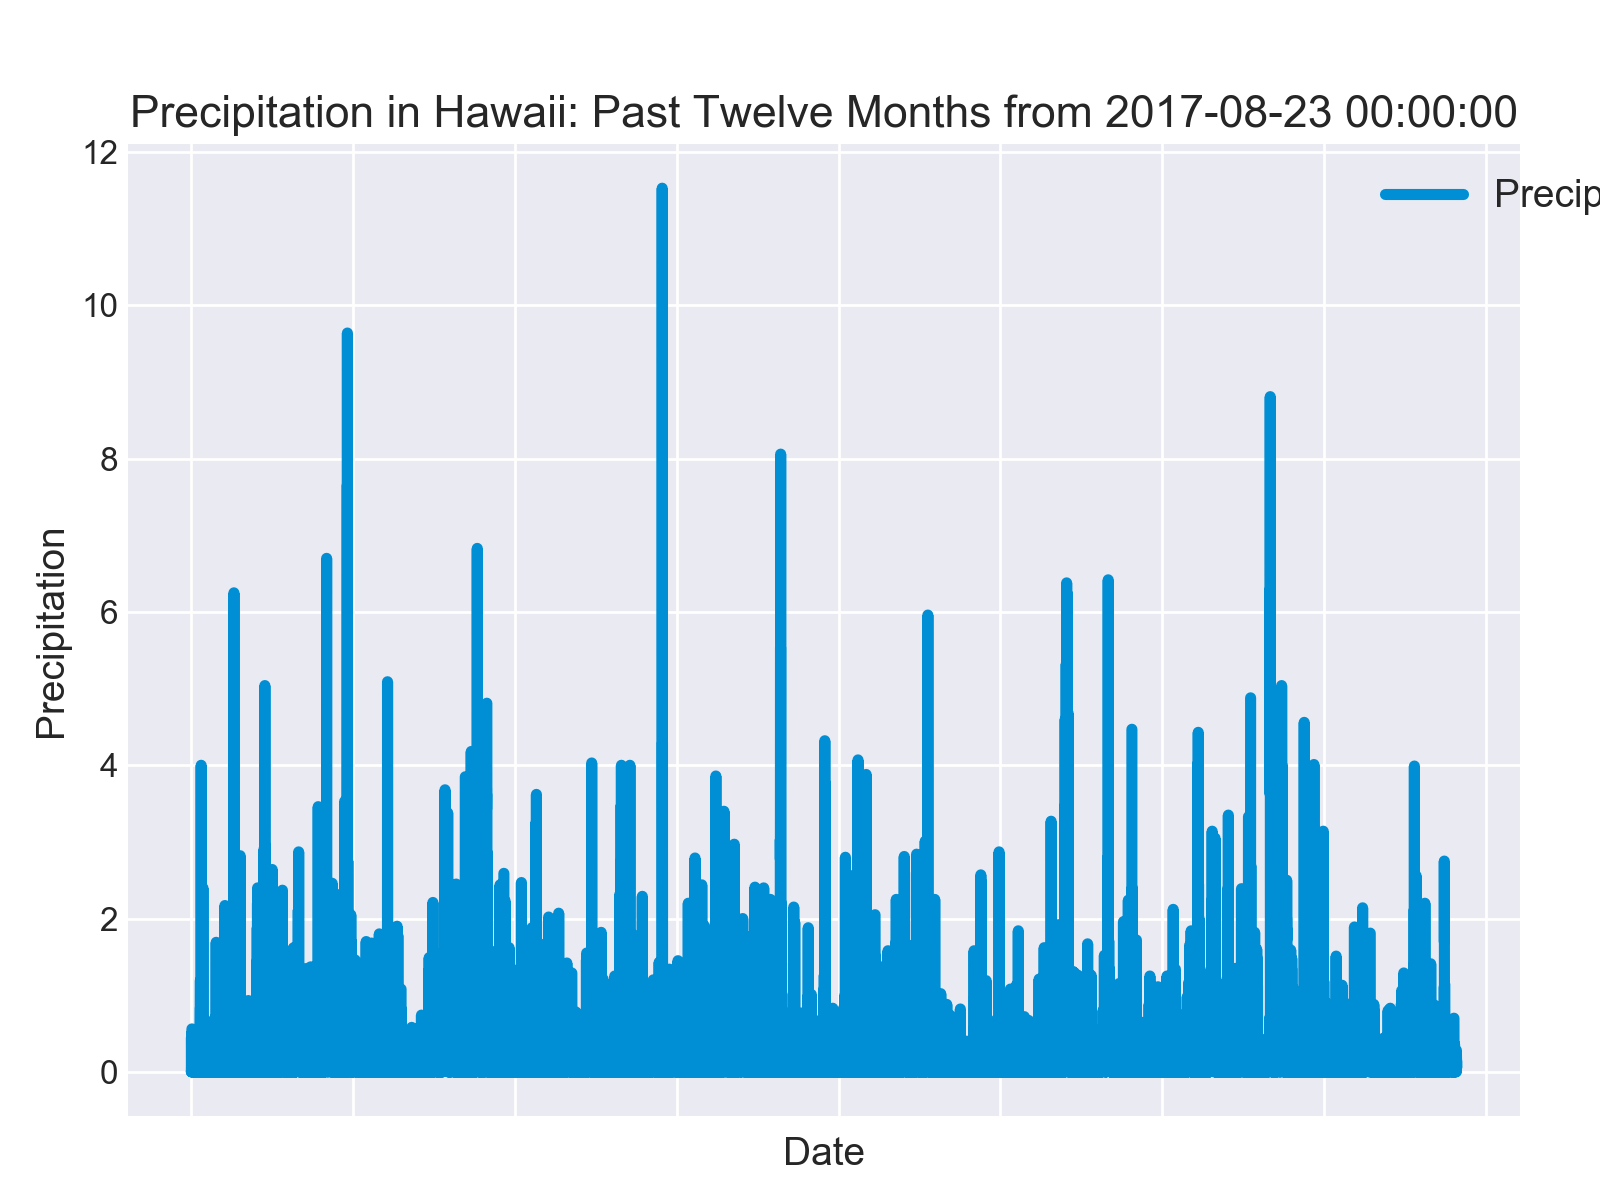

In [62]:
# *** Plot the results using the DataFrame `plot` method. ***
sns.set_style('darkgrid')
Precip_plot = Prcp_df.plot(figsize=(8, 6), label="Precipitation")
plt.title('Precipitation in Hawaii: Past Twelve Months from ' + str(Latest_date), fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Precipitation', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(['Precipitation']).set_bbox_to_anchor((1.16, 1))
plt.show()

In [20]:
# *** Summary stats for Prcp_df *** 
Prcp_df.describe()

,pricp
count,18103.000000
mean,0.160644
std,0.468746
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,11.530000


In [63]:
# *** Query to calculate the total number of stations. ***
station_num = session.query(Station.id).count()
print('Number of stations: ' + str(station_num))

Number of stations: 9


In [64]:
'''' *** Query to find the most active stations. ***
  * List the stations and observation counts in descending order
  * Which station has the highest number of observations?
'''
station_active = session.query(Measurements.station, Stations.name, func.count(Measurements.station))\
                                .join(Station, Measurements.station == Stations.station)\
                                .group_by(Measurements.station)\
                                .order_by(func.count(Measurements.station).desc())

# *** Printing findings ***       
print('Station, station name, and activity count:')
print('**********************')

for instance in station_active:
    print(instance)

station_most = station_active[0][0]
name_most = station_active[0][1]

print('**********************')
print('Most Active Station: ' + station_most + ' (' + name_most + ')')

Station, station name, and activity count:
**********************
('USC00519281', 'WAIHEE 837.5, HI US', 2772)
('USC00519397', 'WAIKIKI 717.2, HI US', 2724)
('USC00513117', 'KANEOHE 838.1, HI US', 2709)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202)
('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979)
('USC00517948', 'PEARL CITY, HI US', 1372)
('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)
**********************
Most Active Station: USC00519281 (WAIHEE 837.5, HI US)


In [65]:
''' *** Query to retrieve the last 12 months of temperature observation data (tobs). ***
  * Filter by the station with the highest number of observations.
'''
Last_Temps = session.query(Measurements.date, Measurements.tobs)\
            .filter(Measurements.station==station_most, Measurements.date )

# Check if query was correct 
Last_Temps[0:5]

[('2010-01-01', 70.0),
 ('2010-01-02', 62.0),
 ('2010-01-03', 74.0),
 ('2010-01-04', 75.0),
 ('2010-01-05', 74.0)]

In [66]:
# *** Load the query results into a Pandas DataFrame and set the index to the date column. ***
Date = [row[0] for row in Last_Temps]
Temps = [row[1] for row in Last_Temps]
Last_Temps_df = pd.DataFrame(list(zip(Date, Temps)), columns=['date', 'temp'])
Last_Temps_df.set_index('date', inplace=True)
Last_Temps_df.tail()

,temp
date,
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0
2017-08-17,76.0
2017-08-18,79.0


<IPython.core.display.Javascript object>


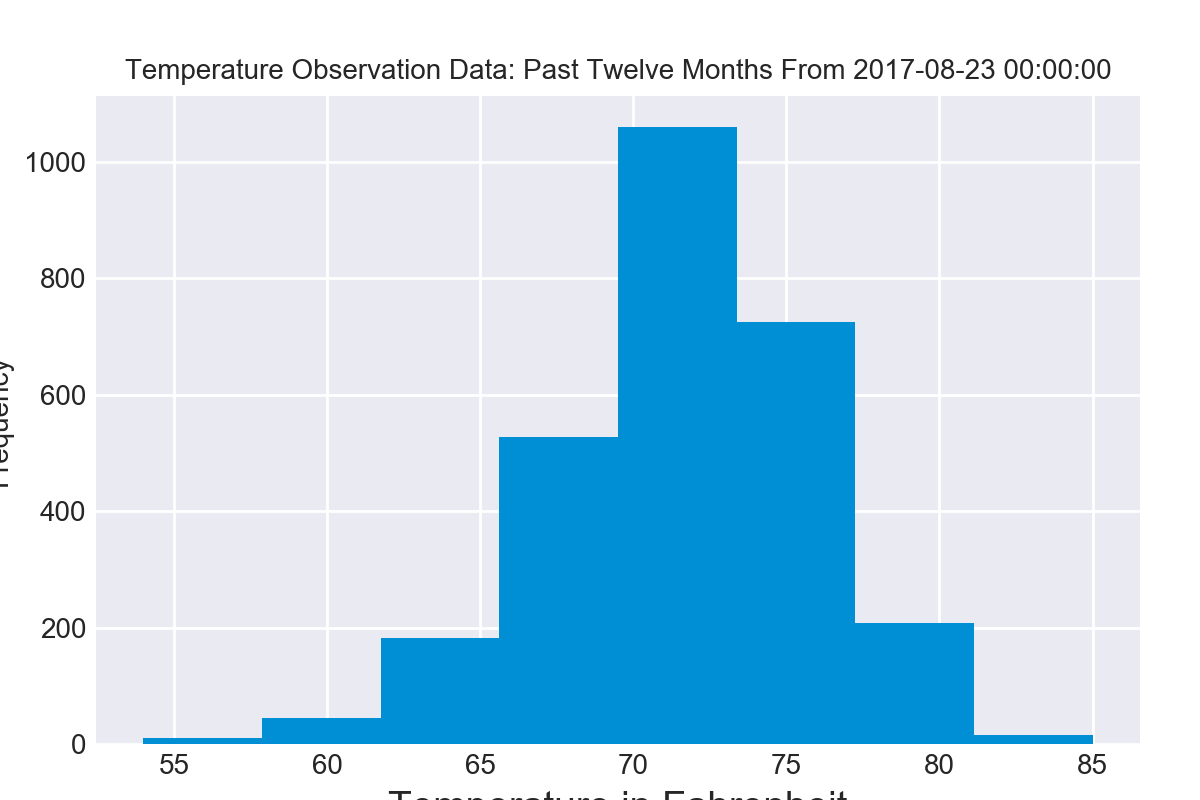

In [67]:
# *** Plot the results as a histogram with `bins=12`. ***
Last_Temps_df.hist(figsize=(6, 4), bins=8)
plt.title('Temperature Observation Data: Past Twelve Months From ' + str(Latest_date), fontsize=10)
plt.xlabel('Temperature in Fahrenheit', fontsize=14)
plt.ylabel('Frequency', fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

In [26]:
''' *** Write a function called `calc_temps` that will accept a start date and end date 
    in the format `%Y-%m-%d` and return the minimum, average, and maximum temperatures 
    for that range of dates. ***
'''
def calc_temps(start_date, end_date):
    try:
        temp_range = session.query(Measurements.date, func.min(Measurements.tobs), \
                    func.avg(Measurements.tobs), func.max(Measurements.tobs))\
                    .filter(Measurements.date.between(start_date, end_date))\
                    .group_by(Measurements.date)\
                    .order_by(Measurements.date)
        return(temp_range)
        
    except ValueError:
        print('There was a wrong parameter!')

In [68]:
# *** Calculate tempuratures for my "vacation" ***
    # This years vacation is from '2018-08-20' to '2018-08-27'
    # I will use last year's values to calculate what to expect on this year's trip
vacation = calc_temps('2017-08-20', '2017-08-27')

for days in vacation:
    print(days)

('2017-08-20', 78.0, 79.66666666666667, 81.0)
('2017-08-21', 76.0, 79.5, 82.0)
('2017-08-22', 76.0, 80.0, 82.0)
('2017-08-23', 76.0, 80.25, 82.0)


In [69]:
# *** Save vacation weather data into a df ***
vacation_dic = {'date':[], 'min_temp':[], 'avg_temp':[], 'max_temp':[], 'range_temp':[]}
for day in vacation:
    vacation_dic['date'].append(day[0])
    vacation_dic['min_temp'].append(day[1])
    vacation_dic['avg_temp'].append(day[2])
    vacation_dic['max_temp'].append(day[3])
    vacation_dic['range_temp'].append(day[3] - day[1]) # The day's Max temp - min temp
    
vacation_df = pd.DataFrame(vacation_dic)
vacation_df.set_index('date', inplace=True)

vacation_df

,avg_temp,max_temp,min_temp,range_temp
date,,,,
2017-08-20,79.666667,81.0,78.0,3.0
2017-08-21,79.500000,82.0,76.0,6.0
2017-08-22,80.000000,82.0,76.0,6.0
2017-08-23,80.250000,82.0,76.0,6.0


<IPython.core.display.Javascript object>


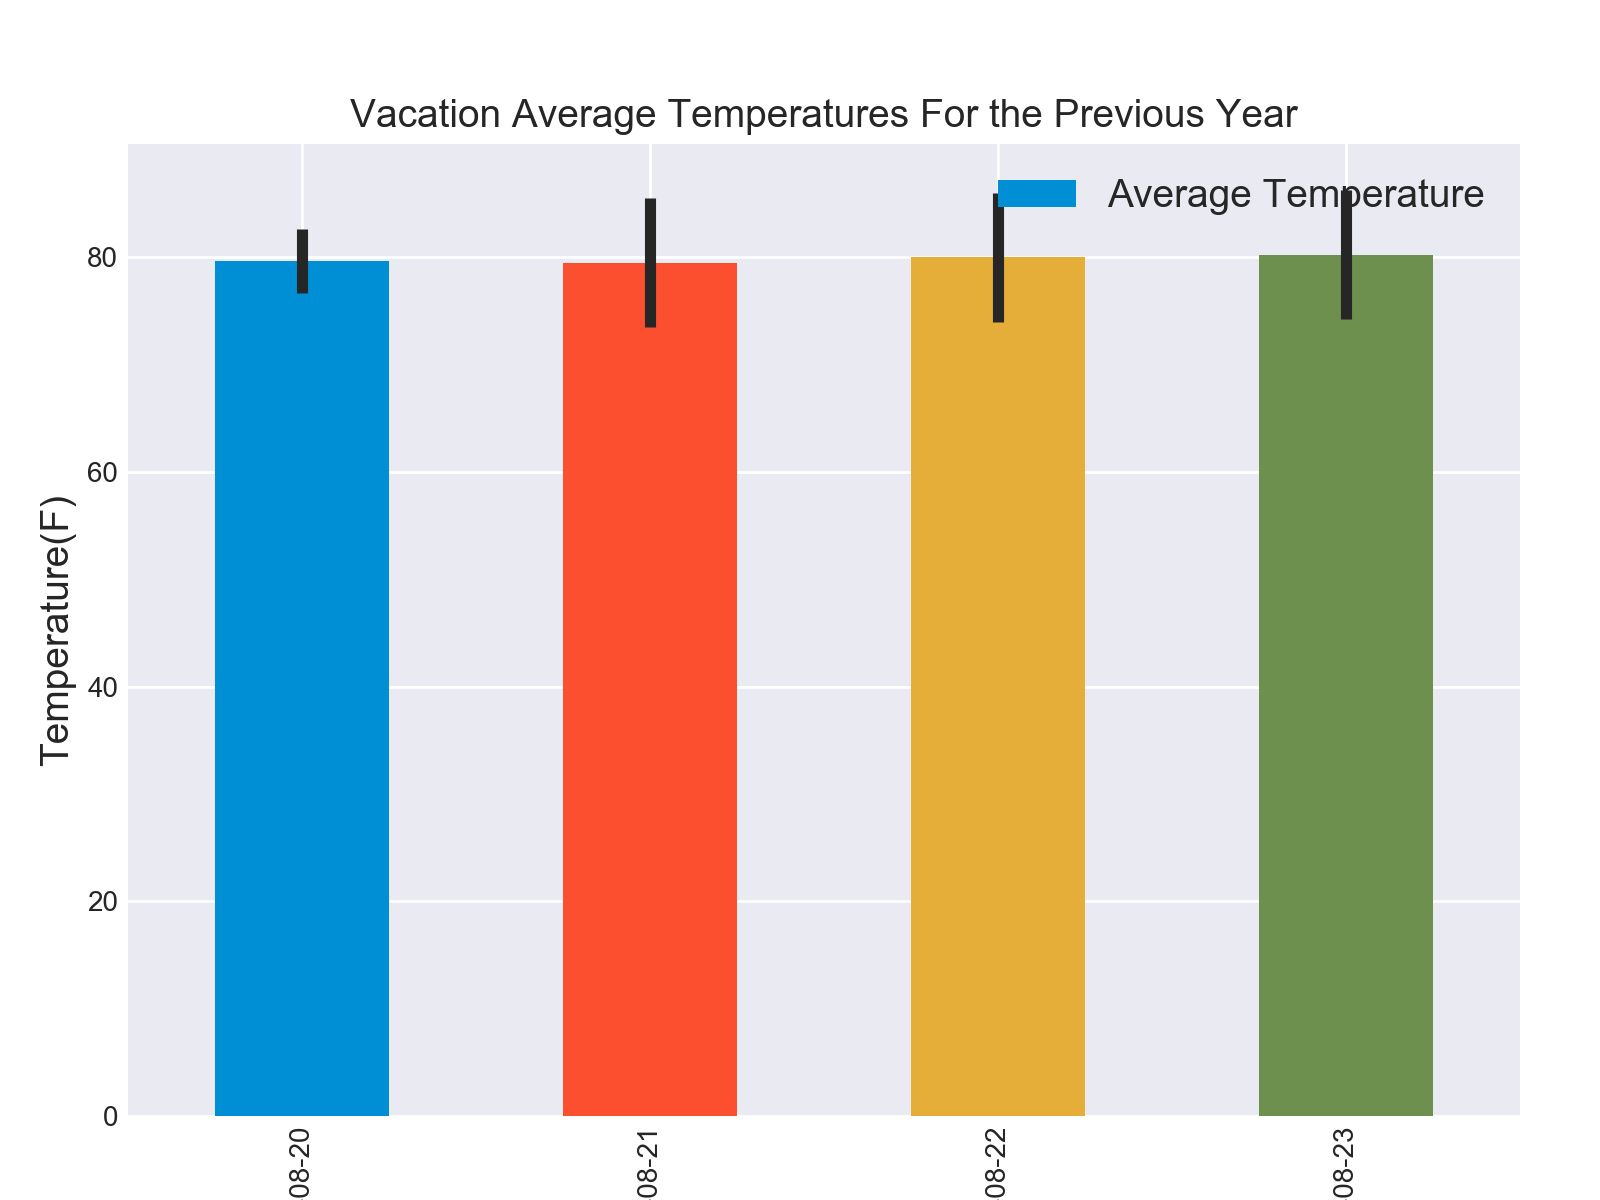

In [70]:
'''' *** Plot the min, avg, and max temperature from your previous query as a bar chart. ***
  * Use the average temperature as the bar height.
  * Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).
'''
vacation_df.plot(x=vacation_df.index, y='avg_temp', kind='bar', yerr='range_temp', figsize=(8, 6), fontsize=10)
plt.title("Vacation Average Temperatures For the Previous Year", fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Temperature(F)', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.legend(['Average Temperature']).set_bbox_to_anchor((1, 1))

plt.show()



In [30]:
# *** Calcualte the rainfall per weather station using the previous year's matching dates. ***
    # Note: I assume the input dates are the dates I previously selected as my "vacation days"
    # vacation dates = '2017-08-20' to '2017-08-27'
V_start = pd.to_datetime('2017-08-20') 
V_end = pd.to_datetime('2017-08-27')
prevYrStart = V_start - timedelta(days=365)
prevYrEnd = V_end - timedelta(days=365)

# Query dates, station names, and precipitation for each station, 
    # where dates between previous year's vacation dates
prev_prcp = session.query(Measurements.date, Stations.name, Measurements.prcp)\
            .join(Stations, Measurements.station == Stations.station)\
            .order_by(Stations.name)

# check query
prev_prcp[-5:-1]
prev_prcp[0:7]

[('2010-01-01', 'HONOLULU OBSERVATORY 702.2, HI US', 0.05),
 ('2010-01-02', 'HONOLULU OBSERVATORY 702.2, HI US', 0.0),
 ('2010-01-03', 'HONOLULU OBSERVATORY 702.2, HI US', 0.0),
 ('2010-01-04', 'HONOLULU OBSERVATORY 702.2, HI US', 0.0),
 ('2010-01-05', 'HONOLULU OBSERVATORY 702.2, HI US', 0.0),
 ('2010-01-06', 'HONOLULU OBSERVATORY 702.2, HI US', 0.08),
 ('2010-01-07', 'HONOLULU OBSERVATORY 702.2, HI US', 0.04)]

In [71]:
''' *** Create a function called `daily_normals` that will calculate the daily normals for 
    a specific date. 
    This date string will be in the format `%m-%d`. 
'''
def daily_normals(date):
    try:
        date = date.split("-")
        month = date[0]
        day = date[1]
        norm_date = session.query(Measurements.date, Measurements.station, func.min(Measurements.tobs),\
                    func.avg(Measurement.tobs), func.max(Measurement.tobs))\
                    .filter(extract('month', Measurements.date) == month, extract('day', Measurements.date) == day)\
                    .group_by(extract('month', Measurements.date), extract('day', Measurements.date))
        
        
        return norm_date
    
    
    except ValueError:
        print('There was a wrong parameter!')

In [72]:
# test daily_normals()

test_date = daily_normals('08-20')
for instance in test_date:
    print(instance)
test_date[0][2]

('2011-08-20', 'USC00519523', 68.0, 76.45283018867924, 82.0)


68.0

In [73]:
''' *** Create a list of dates for your trip in the format `%m-%d`. 
    Use the `daily_normals` function to calculate the normals for each date string and
    append the results to a list. ***
'''
date_ls = []
start_date = '08-20'
end_date = '08-27'
d = datetime.strptime(start_date, '%m-%d')
date_ls.append(d.strftime('%m-%d'))

# generate date range while end_date not in date_ls
count = 0
while end_date not in date_ls:
    day = datetime.strptime(date_ls[count], '%m-%d')
    add_day = day + timedelta(days=1)
    add_day = add_day.strftime('%m-%d')
    date_ls.append(add_day)
    count += 1
    print('date appended')

date_ls

date appended
date appended
date appended
date appended
date appended
date appended
date appended


['08-20', '08-21', '08-22', '08-23', '08-24', '08-25', '08-26', '08-27']

In [74]:
# *** Use the `daily_normals` function to calculate the normals for each date string and 
    # append the results to a list.
tempNorm_ls = []

count = 0
for date in date_ls:
    norm = daily_normals(date)[0]
    tempNorm_ls.append({'date': date_ls[count], 'min': norm[2], 'avg': norm[3], 'max': norm[4]})
    count += 1
tempNorm_ls

[{'avg': 76.45283018867924, 'date': '08-20', 'max': 82.0, 'min': 68.0},
 {'avg': 76.4, 'date': '08-21', 'max': 83.0, 'min': 67.0},
 {'avg': 76.47169811320755, 'date': '08-22', 'max': 84.0, 'min': 69.0},
 {'avg': 76.6923076923077, 'date': '08-23', 'max': 87.0, 'min': 67.0},
 {'avg': 75.96153846153847, 'date': '08-24', 'max': 84.0, 'min': 70.0},
 {'avg': 76.96078431372548, 'date': '08-25', 'max': 82.0, 'min': 69.0},
 {'avg': 76.56862745098039, 'date': '08-26', 'max': 84.0, 'min': 71.0},
 {'avg': 76.28301886792453, 'date': '08-27', 'max': 84.0, 'min': 68.0}]

# Exploratory Climate Analysis

In [75]:
# *** Load the list of daily normals into a Pandas DataFrame and set the index equal to the date. ***
dailyNorms_df = pd.DataFrame(tempNorm_ls)
dailyNorms_df.set_index('date', inplace=True)
dailyNorms_df.head()

,avg,max,min
date,,,
08-20,76.452830,82.0,68.0
08-21,76.400000,83.0,67.0
08-22,76.471698,84.0,69.0
08-23,76.692308,87.0,67.0
08-24,75.961538,84.0,70.0


<IPython.core.display.Javascript object>


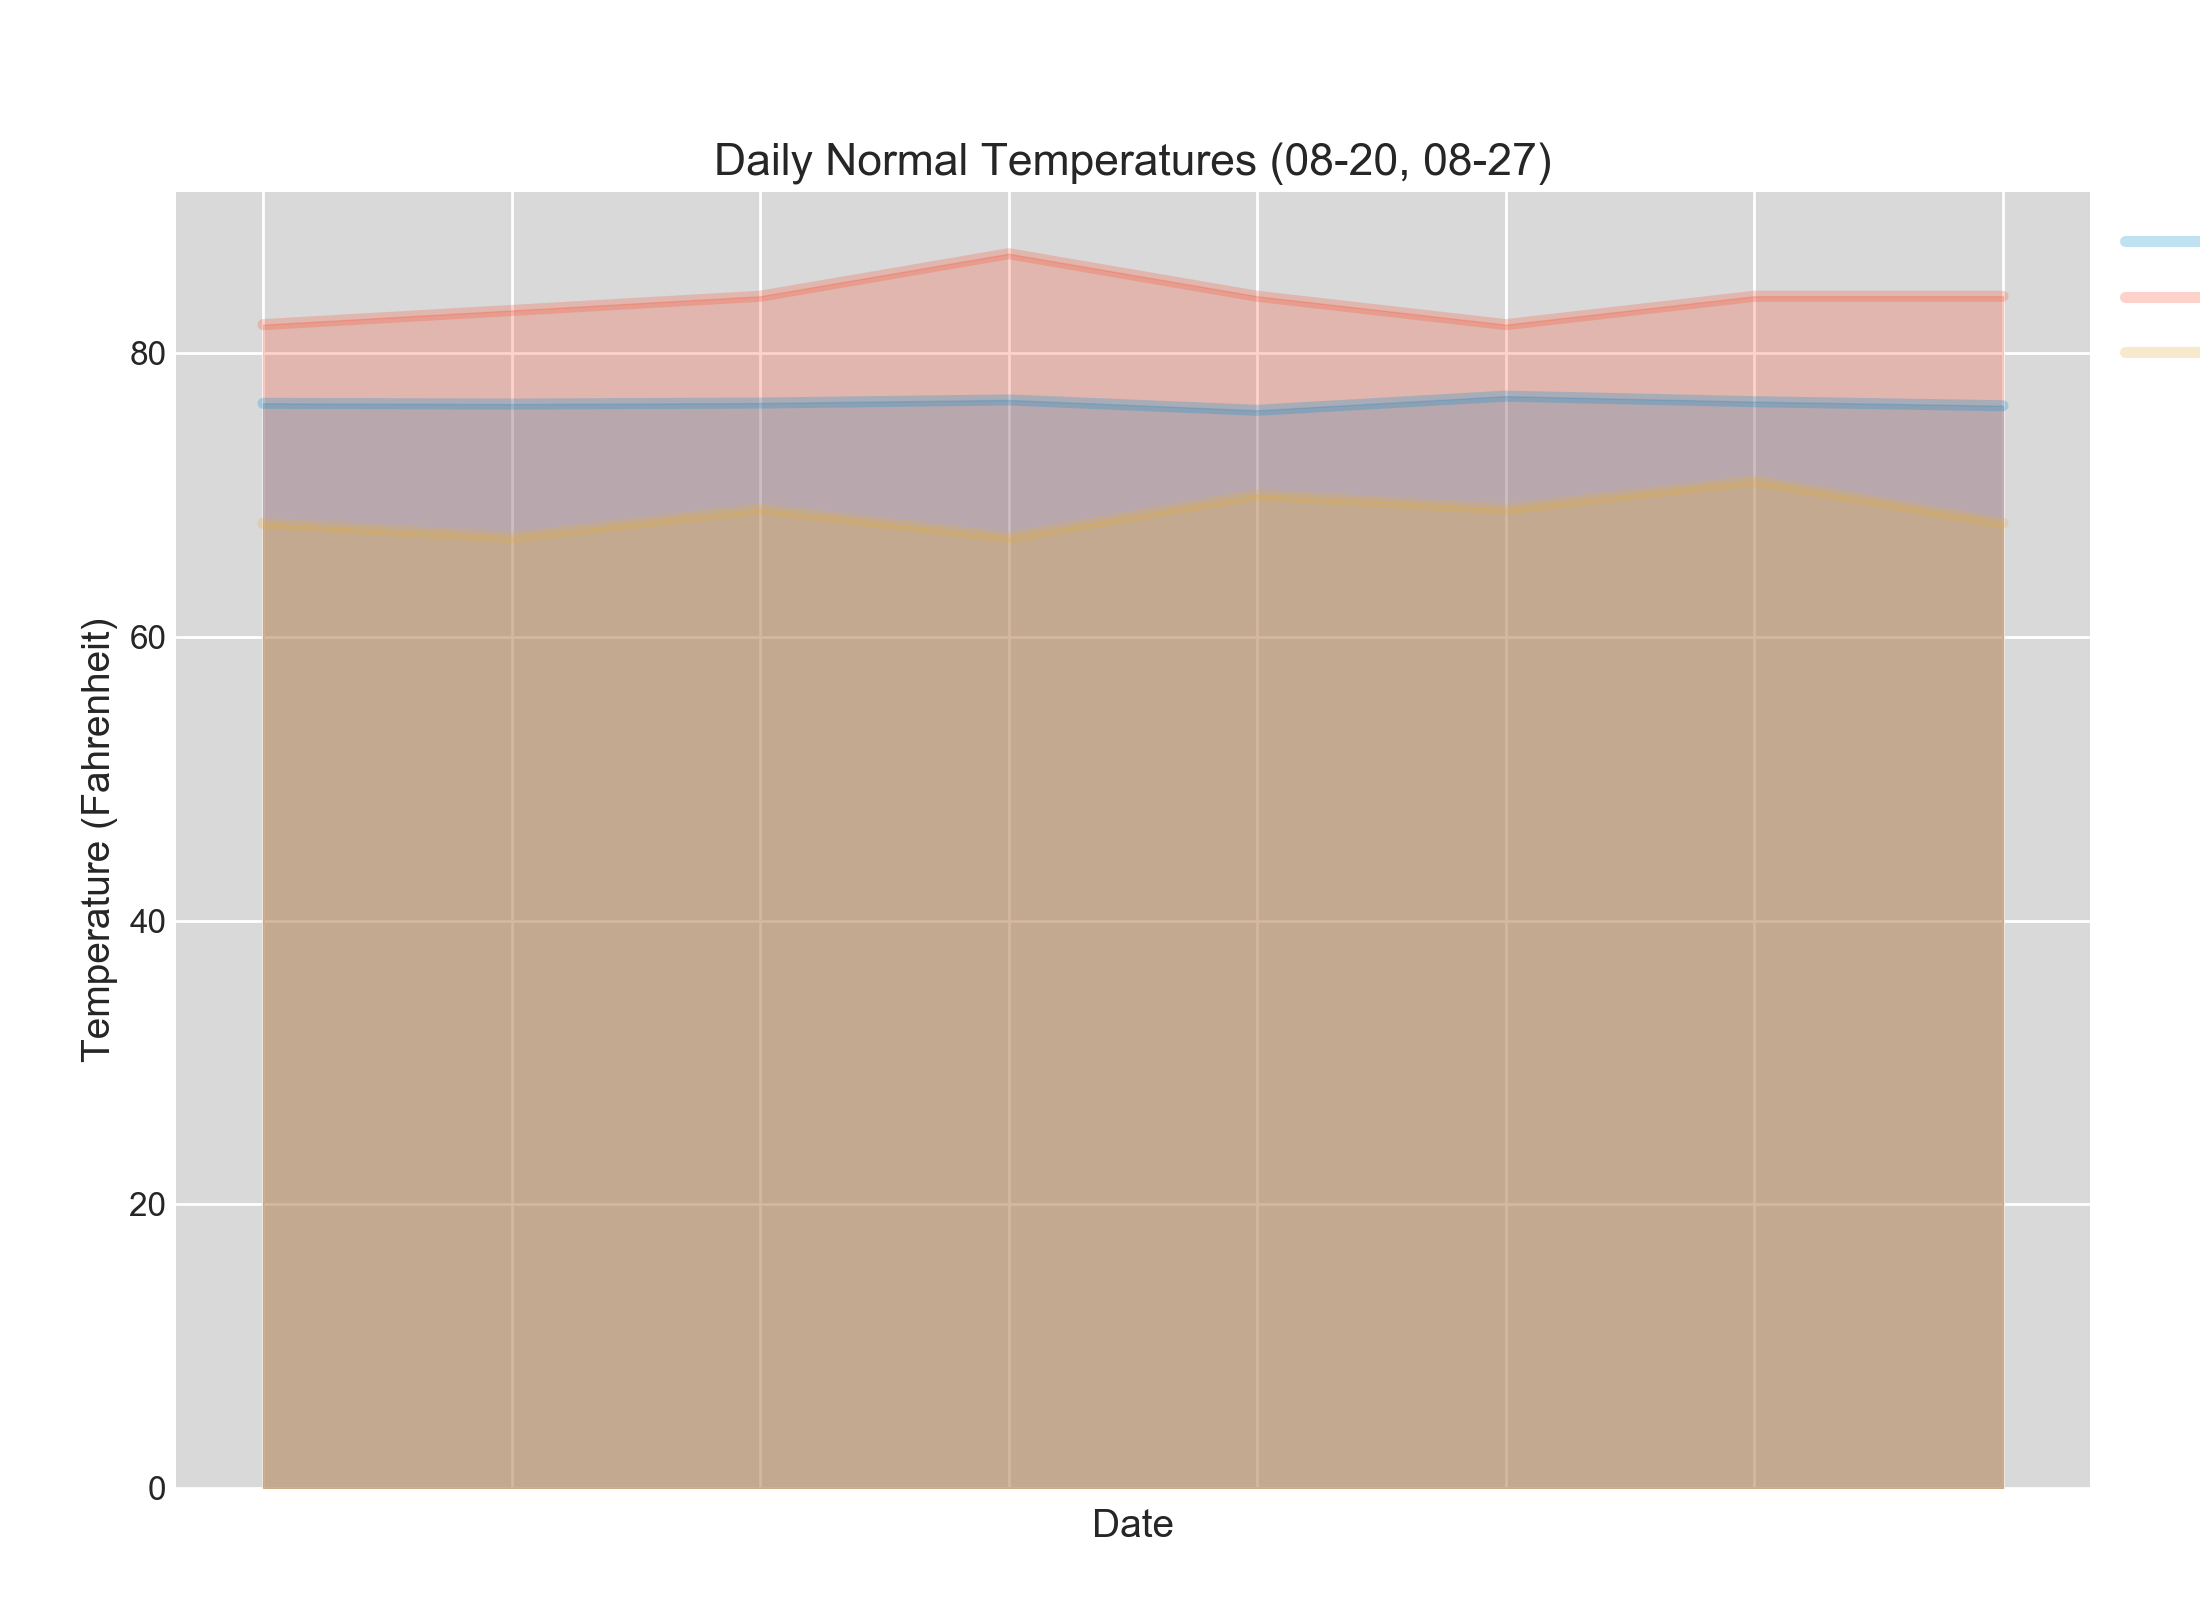

In [76]:
# *** Use Pandas to plot an area plot (`stacked=False`) for the daily normals. ***
sns.set_style("darkgrid", {"axes.facecolor": ".85"})
dailyNorms_df.plot.area(stacked=False, figsize=(11, 8), alpha=0.25)
plt.title('Daily Normal Temperatures (' + start_date + ', ' + end_date + ')', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Temperature (Fahrenheit)', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(['Average', 'Max', 'Min']).set_bbox_to_anchor((1, 1))
plt.show()

In [ ]:
# *** Design a Flask api based on the queries that you have just developed. ***
app = Flask(__name__)

# App route at the start
@app.route('/')
def welcome():
    # Returns strings informing user of all available api routes
        # note: HTML line breaks work here, not python \n
    return("Welcome to my Hawaii Weather API! </br>" 
        "Available api routes: </br>"
        "Average Precipitation for the last 12 months: /api/v1.0/precipitation </br>"
        "List of Stations: /api/v1.0/stations </br>"
        "List of Temperature Observations (tobs) for the last 12 months: /api/v1.0/tobs </br>"
        "List of temperatures for a given start range: /api/v1.0/start_date </br>"
        "List of temperatures for a given start-end range: /api/v1.0/start_date/end_date </br>"
        "Note: start_date and end_date are variables of dates (format: YYYY-MM-DD)"
    )

In [ ]:
# *** API route for json of precipitation ***
    # See Precipitation Analysis section for prcp variables used here
@app.route('/api/v1.0/precipitation')
def show_precip():
    data = []
  #  '''copy/paste from the previous query: 
    date = [row[0] for row in Last12Precip]
    prcp = [row[2] for row in Last12Precip]'''
    data_row_count = 0
    for row in Last12Precip:
        data.append({'date':row[0], 'station_name':row[1], 'avg_prcp':row[2]})
    return jsonify(data)

In [ ]:
# Test to see if the for loop within show_precip() worked
data = []
for row in Last12Precip:
        data.append({'date':row[0], 'station_name':row[1], 'avg_prcp':row[2]})
print(str(data[0]))

In [ ]:
# *** API route for a list of stations from the dataset ***
@app.route('/api/v1.0/stations')
def show_stations():
    station_ls = []
    # Note: station_active is found in the Station Analysis section
    for row in station_active:
        station_ls.append({'station':row[0], 'name':row[1]})
    return jsonify(station_ls)

In [ ]:
# Test to see if the for loop within show_stations() worked
station_ls = []
    # Note: station_active is found in the Station Analysis section
for row in station_active:
    station_ls.append({'station':row[0], 'name':row[1]})

print(station_ls)

In [ ]:
# *** API route for json of Temperature Observations (tobs) for the last 12 months ***
@app.route('/api/v1.0/tobs')
def show_tobs():
    temps_ls = [] 
    all_temps = calc_temps(year_date, Latest_date) 
        # note: year_date and Latest_date are in precipitation analysis section
    for days in all_temps:
        temps_ls.append({'date':days[0], 'min_temp':days[1], 'avg_temp':days[2], 'max_temp':days[3]})
    return jsonify(temps_ls)

In [ ]:
temps_ls = [] 
all_temps = calc_temps(year_date, Latest_date)
for days in all_temps:
    temps_ls.append({'date':days[0], 'min_temp':days[1], 'avg_temp':days[2], 'max_temp':days[3]})
    
print(temps_ls[0:2])
print(temps_ls[-1])

In [ ]:
# *** API route for json of temps for a given start or start-end range. ***
# First, create function that will be used for both app routes 
    # gets dates based on temperatures
def temps_dates(start = Latest_date, end = Latest_date): 
    temps_ls = []
    get_temps = calc_temps(start, end)
    for days in get_temps:
        temps_ls.append({'date':days[0], 'min_temp':days[1], 'avg_temp':days[2], 'max_temp':days[3]})
    return temps_ls

# Note: Latest_date var at Precipitation Analysis section

In [ ]:
# *** API routes for inputted temps  ***
@app.route('/api/v1.0/<start>')
def start_temps_api(start):
    return jsonify(temps_dates(start))

@app.route('/api/v1.0/<start>/<end>')
def all_temps_api(start, end):
    return jsonify(temps_dates(start, end))

In [ ]:
# Test to see if the for loop within temps_api_dates() worked
for i in temps_dates('2017-08-16', '2017-08-20'):
    print(i)

In [ ]:
# *** run app ***
if __name__ == '__main__':
    app.run()